Số quan sát: 40
Số biến đầu vào: 5
Các biến: ['GDP', 'Inflation', 'Population', 'FDI', 'TradeBalance']
Train samples: 30
Test samples : 5
Huấn luyện RNN hoàn tất
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step

===== ĐÁNH GIÁ RNN ĐA BIẾN =====
MAE  = 24,460,735,751 USD
RMSE = 28,377,477,525 USD
R²   = 0.6294


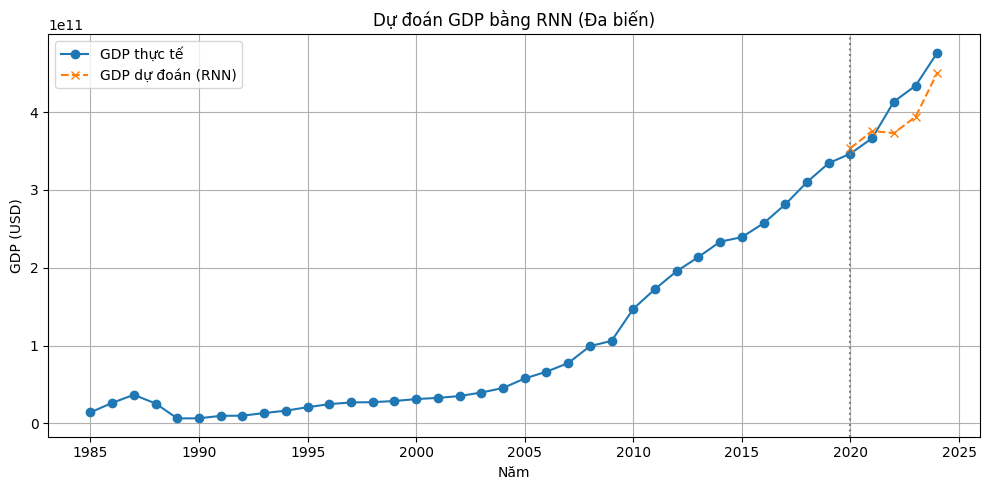

In [2]:
# ===== RNN (SimpleRNN) DỰ ĐOÁN GDP =====

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import Adam

# 1. LOAD DATA
df = pd.read_csv("macro_vietnam_processed.csv")
df = df.sort_values("Year").reset_index(drop=True)

years = df["Year"].values

# 2. CHỌN CÁC BIẾN ĐẦU VÀO
feature_cols = ['GDP', 'Inflation', 'Population', 'FDI', 'TradeBalance']
X_data = df[feature_cols].values
gdp = df["GDP"].values  # Để vẽ biểu đồ so sánh

print("Số quan sát:", len(X_data))
print("Số biến đầu vào:", len(feature_cols))
print("Các biến:", feature_cols)

# 3. SCALE TẤT CẢ CÁC BIẾN
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_data)

# Tạo scaler riêng cho GDP để inverse_transform dự đoán
gdp_scaler = MinMaxScaler()
gdp_scaled = gdp_scaler.fit_transform(gdp.reshape(-1, 1))

# 4. TẠO SEQUENCE
def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window, 0])  # Chỉ lấy GDP (cột đầu tiên)
    return np.array(X), np.array(y)

window_size = 5
X, y = create_sequences(X_scaled, window_size)

# 5. TRAIN / TEST SPLIT
n_test = 5

X_train, X_test = X[:-n_test], X[-n_test:]
y_train, y_test = y[:-n_test], y[-n_test:]

years_test = years[window_size + len(X_train):]

print("Train samples:", X_train.shape[0])
print("Test samples :", X_test.shape[0])

# 6. MÔ HÌNH RNN ĐA BIẾN
n_features = len(feature_cols)
model = Sequential([
    Input(shape=(window_size, n_features)),
    SimpleRNN(32, activation="tanh"),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.005),
    loss="mse"
)

# 7. HUẤN LUYỆN
model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=4,
    verbose=0
)

print("Huấn luyện RNN hoàn tất")

# 8. DỰ ĐOÁN & ĐÁNH GIÁ
y_pred_scaled = model.predict(X_test)
y_pred = gdp_scaler.inverse_transform(y_pred_scaled)
y_test_real = gdp_scaler.inverse_transform(y_test.reshape(-1, 1))

mae  = mean_absolute_error(y_test_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))
r2   = r2_score(y_test_real, y_pred)

print("\n===== ĐÁNH GIÁ RNN ĐA BIẾN =====")
print(f"MAE  = {mae:,.0f} USD")
print(f"RMSE = {rmse:,.0f} USD")
print(f"R²   = {r2:.4f}")

# 9. BIỂU ĐỒ
plt.figure(figsize=(10,5))
plt.plot(years, gdp, label="GDP thực tế", marker="o")
plt.plot(years_test, y_pred, 
         label="GDP dự đoán (RNN)", 
         marker="x", linestyle="--")
plt.axvline(years_test[0], color="gray", linestyle=":")
plt.xlabel("Năm")
plt.ylabel("GDP (USD)")
plt.title("Dự đoán GDP bằng RNN (Đa biến)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()